<strong> Nome: </strong> Ítalo Maciel de Paiva <br/>
<strong> Disciplina: </strong> Estrutura de Dados II

Sobre o projeto: **gerar uma rede (grafo) dirigida a partir dos links das páginas do Wikipedia, utilizando `NetworkX`, realizar tratamentos de dados e analisar o resultados.**



In [1]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=6fa5e3f5f616efec4ea6f07ba3b9796e0d9670892d82bdd53251f7600bb3b73f
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [2]:
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import pandas as pd

### Declaração dos dados de entrada

In [3]:
#https://pt.wikipedia.org/wiki/Buraco_negro
SEED = "Buraco Negro".title()
STOPS = ()

# Funções que serão utilizadas


## Função 1: Coleta os dados

A função `data_collect` coleta dados de páginas da Wikipedia para criar um grafo de rede. Ela recebe uma página inicial(`SEED`) e uma lista de termos a serem excluídos (`STOPS`). A função percorre as páginas, coleta os links e os adiciona ao grafo. O processo é repetido até atingir um determinado nível. No final, o grafo resultante é retornado.

In [4]:
def data_collect(SEED, STOPS):
  print('Coletando...')

  todo_lst = [(0, SEED)] # The SEED is in the layer 0
  todo_set = set(SEED) # The SEED itself
  done_set = set() # Nothing is done yet

  g = nx.DiGraph()
  layer, page = todo_lst[0]

  #%%time
  while layer < 2:
    # Remove the name page of the current page from the todo_lst,
    # and add it to the set of processed pages.
    # If the script encounters this page again, it will skip over it.
    del todo_lst[0]
    done_set.add(page)

    # Show progress
    #print(layer, page)

    # Attempt to download the selected page.
    try:
      wiki = wikipedia.page(page)
    except:
      print("Could not load", page)
      layer, page = todo_lst[0]
      continue

    for link in wiki.links:
      link = link.title()
      if link not in STOPS and not link.startswith("List Of"):
        if link not in todo_set and link not in done_set:
          todo_lst.append((layer + 1, link))
          todo_set.add(link)
        g.add_edge(page, link)
    layer, page = todo_lst[0]

  print("Resultados: {} nodes, {} edges".format(len(g), nx.number_of_edges(g)))
  return g

## Função 2: limpeza e filtro
A função `data_treatment` recebe um objeto de grafo g como entrada e retorna um subgrafo modificado.  Ela realiza várias etapas de limpeza, como remover arestas e identificar elementos duplicados, além disso, realiza uma filtragem que seleciona apenas os nós do grafo g que têm grau maior ou igual a 2, cria um subgrafo contendo apenas os nós do núcleo selecionados anteriormente e imprime o número de nós e arestas do subgrafo resultante.

In [5]:
def data_treatment(g):
  print("\n# Iiniciando O Tratamento dos Dados\n")
  # make a copy of raw graph
  original = g.copy()

  #Parte 1: LIMPEZA

  # remove self loops
  g.remove_edges_from(nx.selfloop_edges(g))

  # identify duplicates like that: 'network' and 'networks'
  duplicates = [(node, node + "s")
                for node in g if node + "s" in g
              ]

  for dup in duplicates:
    # *dup is a technique named 'unpacking'
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  #print(duplicates)

  duplicates = [(x, y) for x, y in
                [(node, node.replace("-", " ")) for node in g]
                  if x != y and y in g]
  #print(duplicates)

  for dup in duplicates:
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  # nx.contracted creates a new node/edge attribute called contraction
  # the value of the attribute is a dictionary, but GraphML
  # does not support dictionary attributes
  nx.set_node_attributes(g, 0,"contraction")
  nx.set_edge_attributes(g, 0,"contraction")

  #Parte 2: FILTRO

  # filter nodes with degree greater than or equal to 2
  core = [node for node, deg in dict(g.degree()).items() if deg >= 2]

  # select a subgraph with 'core' nodes
  gsub = nx.subgraph(g, core)

  print("Resultados: {} nodes, {} edges".format(len(gsub), nx.number_of_edges(gsub)))

  nx.write_graphml(gsub, "cna.graphml")

  return gsub


#gsub = tratamento_de_dados(g)

# Pipeline

Pipeline é uma sequência de etapas interconectadas, em que a saída de uma etapa alimenta a entrada da próxima. Utilizaremos para reduzir o tempo total de "buscas" na wikipedia e todo tratamento dos dados que realizamos ao executar as diversas funções.

In [6]:
# Class for pipeline
class Pipeline:
    def __init__(self):
        self.tasks = []

    def task(self, depends_on=None):
        idx = 0
        if depends_on:
            idx = self.tasks.index(depends_on) + 1
        def inner(f):
            self.tasks.insert(idx, f)
            return f
        return inner

    def run(self, *args, **kwargs):
        output = args
        for task in self.tasks:
            if isinstance(output, tuple):
                output = task(*output, **kwargs)
            else:
                output = task(output, **kwargs)
        return output

pipeline = Pipeline()

@pipeline.task()
def coleta_do_dado():
    return data_collect(SEED, STOPS)

@pipeline.task(depends_on=coleta_do_dado)
def tratamento_de_dado(g):
    return data_treatment(g)

# Executando o pipeline
pipeline.run()

Coletando...
Could not load Airfoil
Could not load Alitalia


/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Could not load Boac
Could not load C. R. Smith
Could not load Canadair
Could not load Colombia
Could not load Denver
Could not load Douglas Dc-2
Could not load Douglas Dc-3
Could not load Douglas Dc-4E
Could not load Douglas Dc-5
Could not load Douglas Dc-8
Could not load Eastern Air Lines
Could not load Klm
Could not load Msn
Could not load Mcdonnell Douglas Md-90
Could not load Nellis Air Force Base
Could not load Northwest Airlines
Could not load Pan Am
Could not load Roberto Clemente
Could not load Sabena
Could not load South African Airways
Could not load Swissair
Could not load United Airlines
Could not load United Airlines Flight 736
Could not load Western Sahara
Resultados: 36594 nodes, 66353 edges

# Iiniciando O Tratamento dos Dados

Resultados: 9620 nodes, 39421 edges


In [7]:
# Carregar o grafo ajustado
gsub = nx.read_graphml("/content/cna.graphml")

### Analise 1)
 **All together**

A função `all_together` gera um gráfico que analisa as métricas de centralidade de um grafo g. O gráfico consiste em quatro subplots dispostos em uma matriz 2x2. Cada subplot representa uma métrica diferente: `Degree Centrality`, `Closeness Centrality`, `Betweenness Centrality` e `Eigenvector Centrality`.

**Degree Centrality** (Centralidade de Grau):
- Mede o número de conexões de um nó na rede.
- Identifica os nós mais conectados e populares.

**Closeness Centrality** (Centralidade de Proximidade):

- Avalia a distância média de um nó para todos os outros nós.
- Identifica os nós mais próximos e eficientes na comunicação.

**Betweenness Centrality** (Centralidade de Intermediação):

- Mede o quanto um nó atua como uma ponte entre outros pares de nós.
- Identifica os nós que controlam o fluxo de informações na rede.

**Eigenvector Centrality** (Centralidade de Autovetor):

- Atribui uma pontuação aos nós com base na importância de seus vizinhos.
- Identifica os nós conectados a outros nós importantes na rede.

**Nossa analise:**

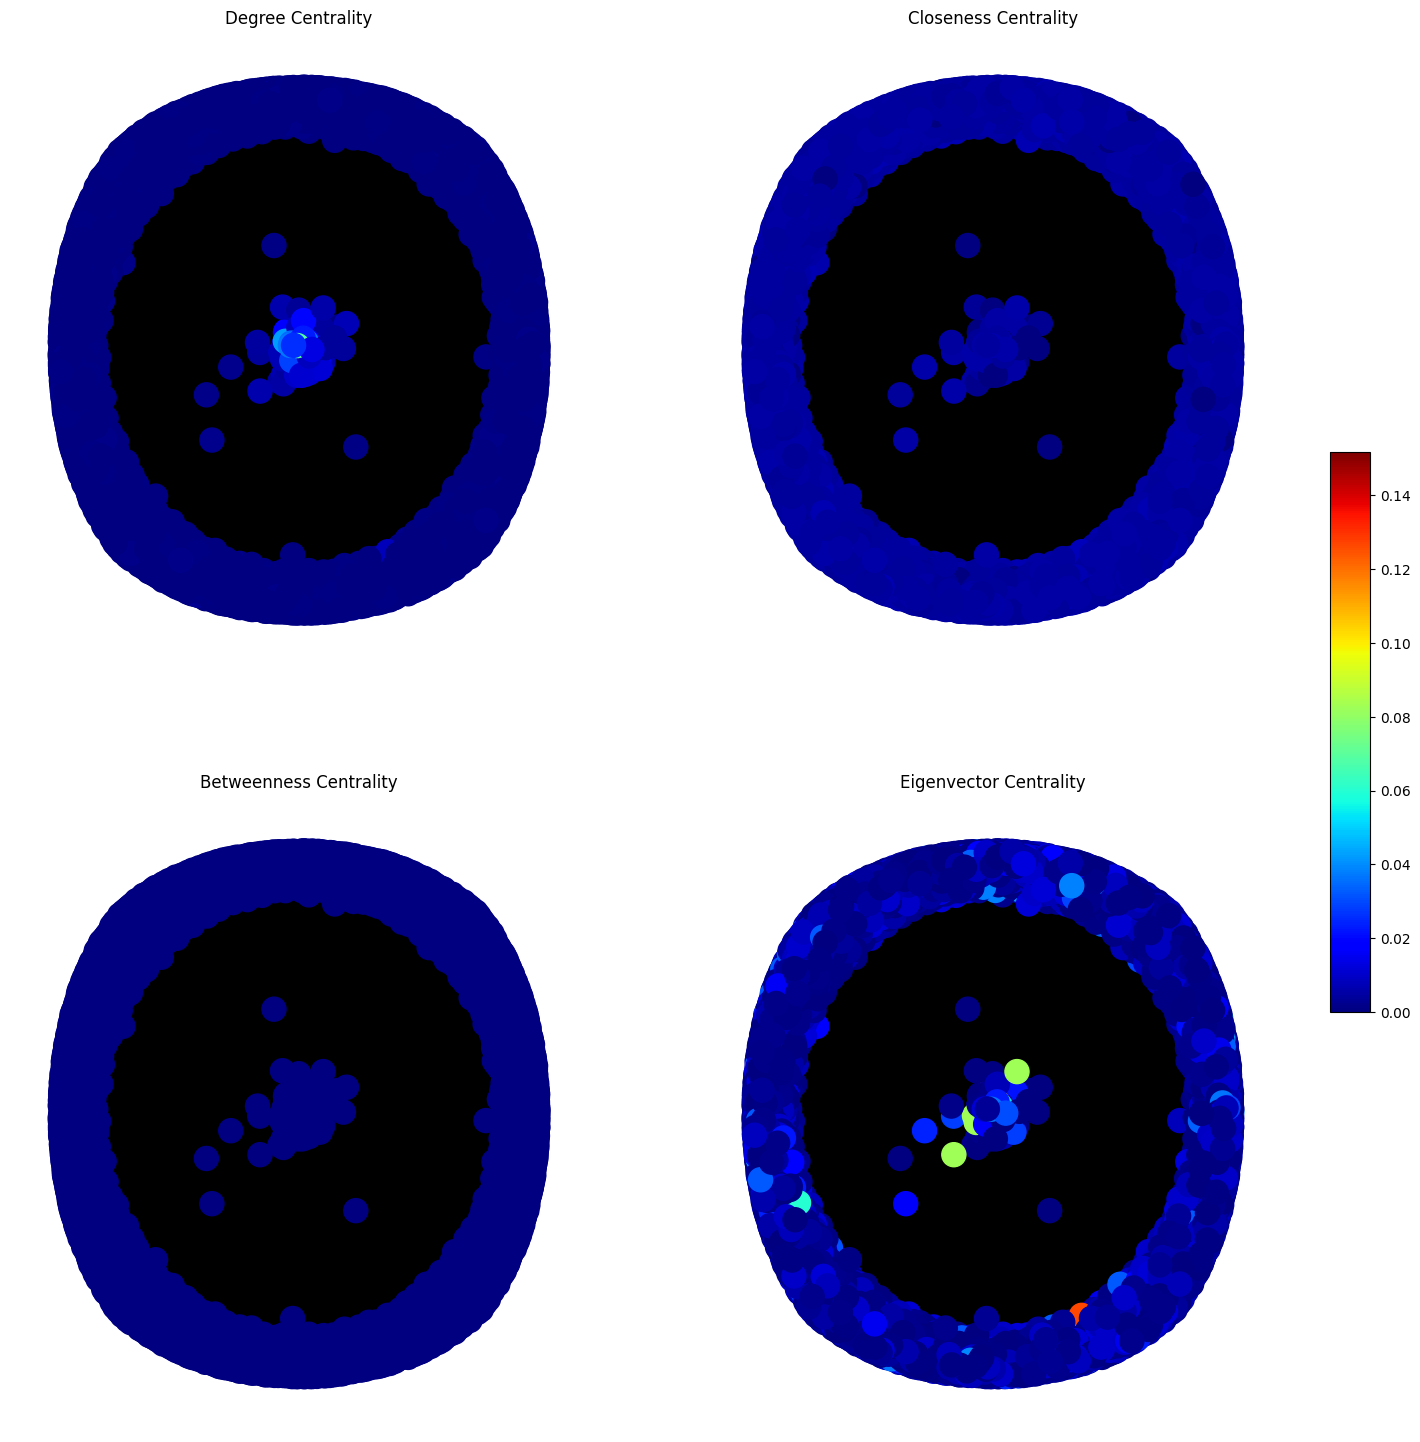

In [ ]:
def all_together(g):
  fig, ax = plt.subplots(2,2,figsize=(16,14))

  eigenvector_centrality = nx.eigenvector_centrality(g)
  degree_centrality = nx.degree_centrality(g)
  closeness_centrality = nx.closeness_centrality(g)
  betweenness_centrality = nx.betweenness_centrality(g)

  # max value of metrics
  max_centrality = max([max([v for k, v in eigenvector_centrality.items()]),
                        max([v for k, v in degree_centrality.items()]),
                        max([v for k, v in closeness_centrality.items()]),
                        max([v for k, v in betweenness_centrality.items()])])

  # layout position
  pos = nx.spring_layout(g, seed=123456789, k=0.3)

  # color of nodes
  color_degree = list(dict(degree_centrality).values())
  color_closeness = list(dict(closeness_centrality).values())
  color_betweenness = list(dict(betweenness_centrality).values())
  color_eigenvector = list(dict(eigenvector_centrality).values())

  #
  # draw edges
  #
  # degree centrality
  nx.draw_networkx_edges(g,
                        pos=pos,
                        alpha=0.4, ax=ax[0,0])

  # closeness centrality
  nx.draw_networkx_edges(g,
                        pos=pos,
                        alpha=0.4, ax=ax[0,1])

  # betweenness centrality
  nx.draw_networkx_edges(g,
                        pos=pos,
                        alpha=0.4, ax=ax[1,0])

  # eigenvector centrality
  nx.draw_networkx_edges(g,
                        pos=pos,
                        alpha=0.4, ax=ax[1,1])

  # draw nodes
  nodes = nx.draw_networkx_nodes(g,
                  pos=pos,
                  node_color=color_degree,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[0,0])
  nodes = nx.draw_networkx_nodes(g,
                  pos=pos,
                  node_color=color_closeness,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[0,1])
  nodes = nx.draw_networkx_nodes(g,
                  pos=pos,
                  node_color=color_betweenness,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[1,0])
  nodes = nx.draw_networkx_nodes(g,
                  pos=pos,
                  node_color=color_eigenvector,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[1,1])


  # eliminate axis
  ax[0,0].axis("off")
  ax[1,0].axis("off")
  ax[0,1].axis("off")
  ax[1,1].axis("off")

  ax[0,0].set_title("Degree Centrality")
  ax[0,1].set_title("Closeness Centrality")
  ax[1,0].set_title("Betweenness Centrality")
  ax[1,1].set_title("Eigenvector Centrality")


  # Create an unique colorbar
  # reference: https://stackoverflow.com/questions/60848582/unique-colorbar-at-the-right-of-multiple-subplots
  plt.subplots_adjust(bottom=0., right=0.92, top=1.)
  cax = plt.axes([0.95, 0.3, 0.025, 0.4])
  sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=max_centrality))
  cbar=plt.colorbar(sm,cax)

  plt.savefig('alltogether.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

  return g

all_together(gsub)

### Analise 2)

**CDF e PDF**

A função draw_CDF_PDF analisa a distribuição dos graus dos nós em um grafo g por meio da criação de um gráfico. A função permite escolher entre plotar a Função de Densidade de Probabilidade (PDF) ou a Função de Densidade Cumulativa (CDF).

O gráfico gerado apresenta duas visualizações sobrepostas:

Histograma: representa a contagem de nós para cada grau presente no grafo. Cada barra vertical do histograma mostra a quantidade de nós que possuem um determinado grau.
Curva de KDE (Kernel Density Estimation): representa a PDF ou a CDF da distribuição dos graus dos nós. Essa curva suavizada oferece uma estimativa da densidade de probabilidade ou da densidade cumulativa da distribuição dos graus.

**Nossa analise:**

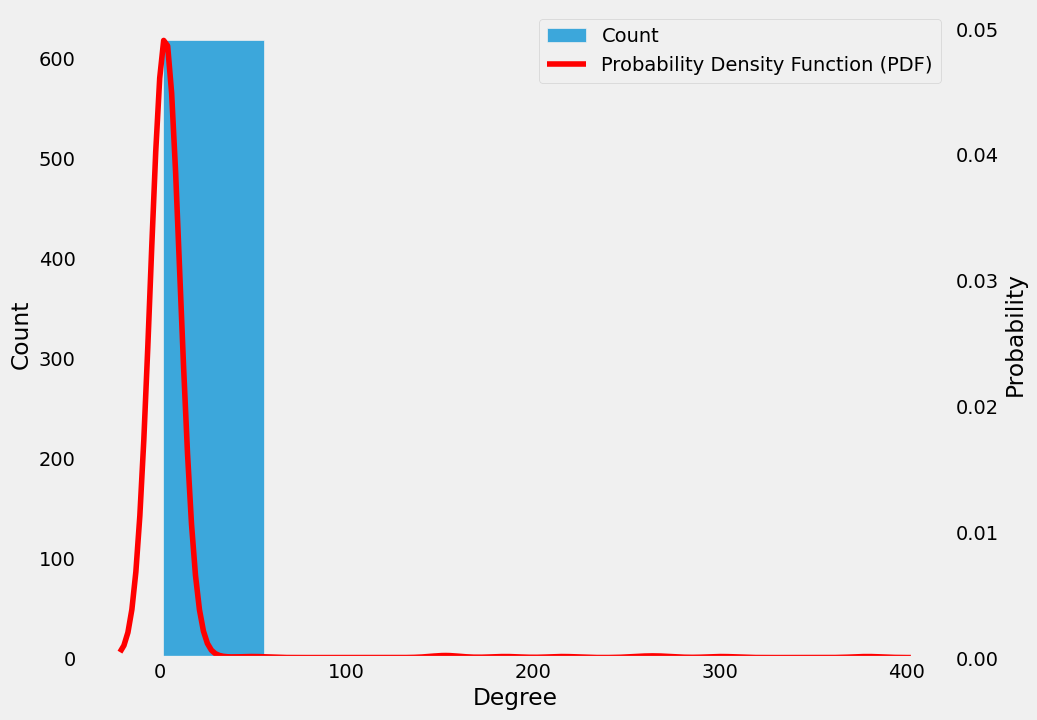

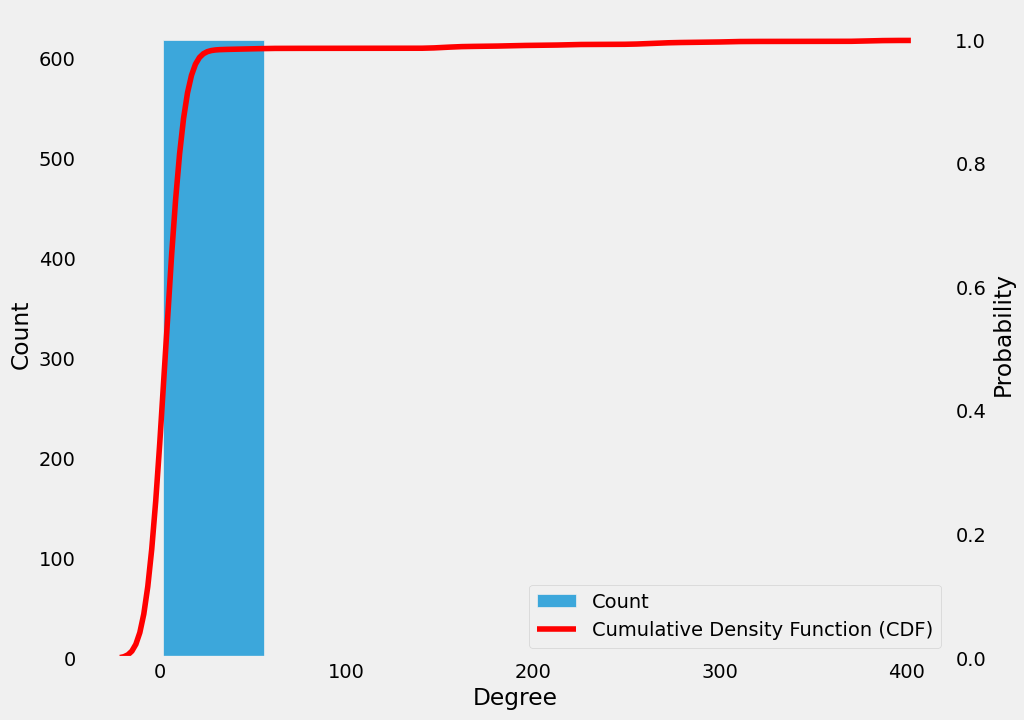

In [ ]:
import seaborn as sns

def draw_CDF_PDF(g, is_CDF=False):
  degree_sequence = sorted([d for n, d in g.degree()], reverse=True)

  plt.style.use("fivethirtyeight")

  fig, ax = plt.subplots(1,1,figsize=(10,8))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()

  new_label = ""
  if is_CDF:
    new_label = "Cumulative Density Function (CDF)"
  else:
    new_label = "Probability Density Function (PDF)"

  sns.kdeplot(degree_sequence,color='r',label=new_label,ax=ax2,cumulative=is_CDF)

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  fig_name = ""
  if is_CDF:
    fig_name = "cumulative_density_function.png"
  else:
    fig_name = "probability_density_function.png"

  plt.savefig(fig_name, transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

draw_CDF_PDF(gsub)
print('\n')
draw_CDF_PDF(gsub, True)

### Analise 3)

**Matriz de gráficos**

A função `draw_matriz` cria uma matriz de gráficos que visualiza as relações entre diferentes métricas de centralidade (Betweenness, Degree, Eigenvector e Closeness) em um grafo g.

**Nossa analise:**

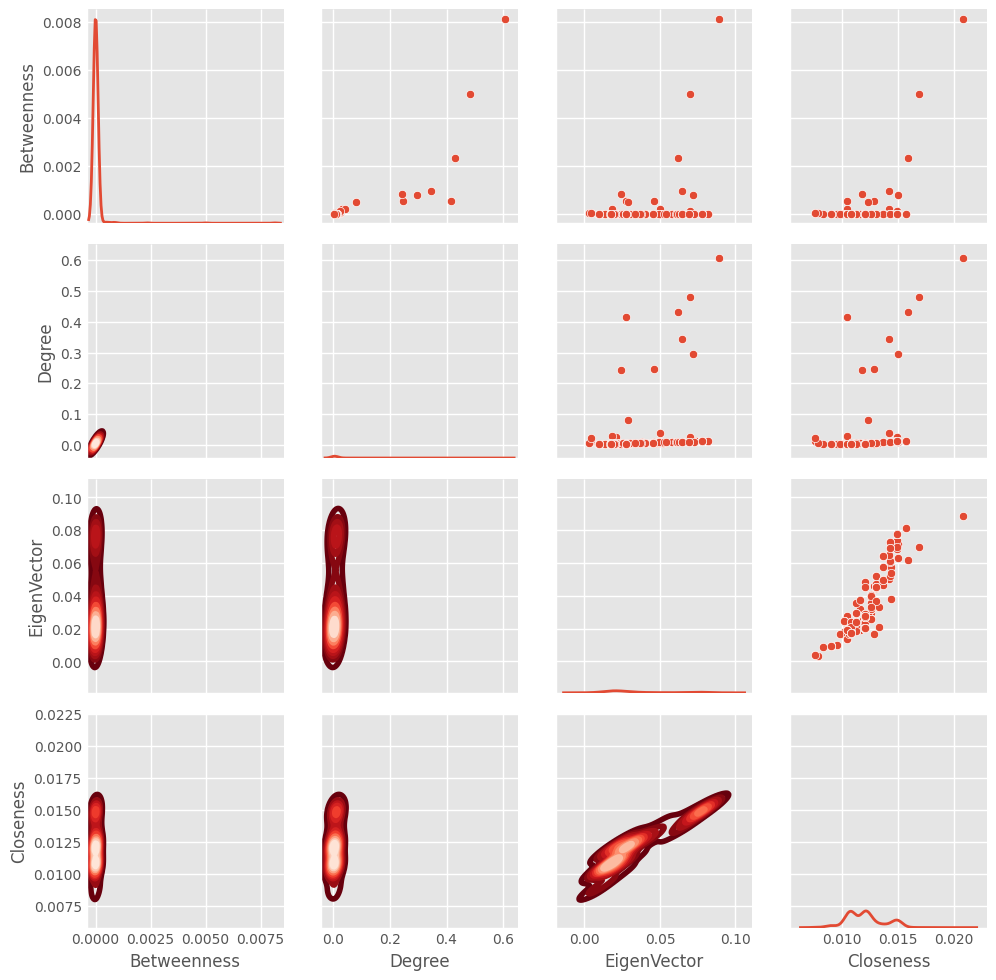

In [ ]:
import pandas as pd

def draw_matriz(g):
  plt.style.use("ggplot")

  bc = pd.Series(nx.betweenness_centrality(g))
  dc = pd.Series(nx.degree_centrality(g))
  ec = pd.Series(nx.eigenvector_centrality(g))
  cc = pd.Series(nx.closeness_centrality(g))

  df = pd.DataFrame.from_dict({"Betweenness": bc,
                              "Degree": dc,
                              "EigenVector": ec,
                              "Closeness": cc})
  df.reset_index(inplace=True,drop=True)
  df.head()

  fig = sns.PairGrid(df)
  fig.map_upper(sns.scatterplot)
  fig.map_lower(sns.kdeplot, cmap="Reds_r")
  fig.map_diag(sns.kdeplot, lw=2, legend=False)

  plt.savefig('all.png', transparent=True,dpi=800,bbox_inches="tight")
  plt.show()

  return g

draw_matriz(gsub)

#### Analise 4)

**Shel e Core**

A função `draw_shell_core` desenha um gráfico para visualizar os conceitos de k-shell e k-core em um grafo g.

**Nossa analise:**

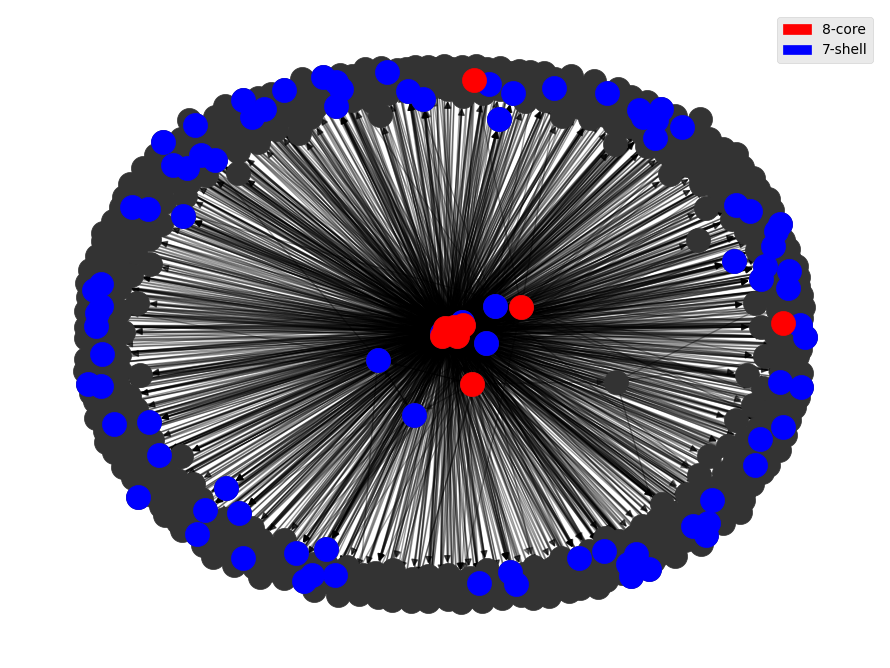

In [ ]:
import matplotlib.patches as mpatches

def draw_shell_core(g):
  # k-core of the network
  temp = set([v for k,v in nx.core_number(g).items()])
  cores_sorted = sorted(list(temp))
  last_core = cores_sorted[-1]
  last_shell = cores_sorted[-2]

  # plot the graph
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # Find k-cores
  g_last_shell = nx.k_shell(g, last_shell)
  g_last_core = nx.k_core(g, last_core)

  # layout position
  pos = nx.spring_layout(g,seed=123456789,k=0.3)

  # draw edges
  nx.draw_networkx_edges(g,
                        pos=pos,
                        alpha=0.4, ax=ax)

  # draw nodes
  nodes = nx.draw_networkx_nodes(g,
                  pos=pos,
                  node_color="#333333")

  # draw nodes
  nodes = nx.draw_networkx_nodes(g_last_shell,
                  pos=pos,
                  node_color="blue")

  nodes = nx.draw_networkx_nodes(g_last_core,
                  pos=pos,
                  node_color="red")

  # static legend
  string_last_shell = f"{last_shell}-shell"
  string_last_core = f"{last_core}-core"

  red_patch = mpatches.Patch(color='red', label=string_last_core)
  blue_patch = mpatches.Patch(color='blue', label=string_last_shell)
  plt.legend(handles=[red_patch,blue_patch])

  plt.axis("off")
  plt.savefig('k-core_sociopatterns.png', transparent=True,dpi=600)
  plt.show()

draw_shell_core(gsub)